In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

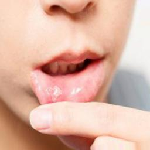

In [5]:
img = image.load_img("/kaggle/input/teeth/Training/CaS/a_100_0_1462.jpg", target_size=(150, 150))
img

In [6]:
cv2.imread("/kaggle/input/teeth/Training/CaS/a_100_0_1462.jpg").shape

(256, 256, 3)

In [8]:
train_dataset.class_indices

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}

In [9]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [4]:
import tensorflow as tf
import os
import logging
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=1.5, alpha=0.5, name='focal_loss'):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = 7

    def call(self, y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)
        ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
        y_true = tf.cast(y_true, tf.float32)
        p_t = tf.reduce_sum(y_true * tf.nn.softmax(y_pred), axis=-1)
        focal_weight = tf.pow(1.0 - p_t, self.gamma)
        return tf.reduce_mean(self.alpha * focal_weight * ce_loss)

    def get_config(self):
        config = super().get_config()
        config.update({"gamma": self.gamma, "alpha": self.alpha, "num_classes": self.num_classes})
        return config

tf.get_logger().setLevel(logging.ERROR)

def augment_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    original_shape = tf.shape(image)[:2]  # [height, width]
    print(f"Original Shape: {original_shape}")  # Debug output
    
    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_flip_left_right(image)
    
    if tf.random.uniform([]) > 0.7:
        try:
            import tensorflow_addons as tfa
            angle = tf.random.uniform([], -0.2, 0.2)
            image = tfa.image.rotate(image, angles=angle, interpolation='BILINEAR')
        except (ImportError, AttributeError):
            print("Warning: tensorflow-addons not found or incompatible. Rotation disabled.")
    
    if tf.random.uniform([]) > 0.6:
        zoom_factor = tf.random.uniform([], 0.8, 1.2)
        h, w = original_shape[0], original_shape[1]
        new_h = tf.cast(tf.cast(h, tf.float32) * zoom_factor, tf.int32)
        new_w = tf.cast(tf.cast(w, tf.float32) * zoom_factor, tf.int32)
        image = tf.image.resize(image, [new_h, new_w])
        image = tf.image.resize_with_crop_or_pad(image, 224, 224)  # Ensure target size
    
    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
    
    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    
    if tf.random.uniform([]) > 0.7:
        image = tf.image.random_hue(image, max_delta=0.05)
    
    if tf.random.uniform([]) > 0.6:
        noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.02)
        image = image + noise
    
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    # Force final resize to ensure (224, 224)
    final_shape = tf.shape(image)[:2]
    print(f"Pre-Resize Shape: {final_shape}")  # Debug output
    if final_shape[0] != 224 or final_shape[1] != 224:
        print(f"Warning: Image shape {final_shape} does not match expected (224, 224). Resizing...")
        image = tf.image.resize(image, [224, 224])
    final_shape = tf.shape(image)[:2]
    print(f"Post-Resize Shape: {final_shape}")  # Debug output
    
    return image, label

def load_dataset(data_dir, image_size=(224, 224), batch_size=32, is_training=True):
    if not os.path.exists(data_dir):
        raise ValueError(f"Dataset directory {data_dir} does not exist. Please check the path.")
    
    dataset = image_dataset_from_directory(
        data_dir,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='int',
        shuffle=is_training,
        seed=42 if is_training else None
    )
    
    class_names = dataset.class_names
    
    total_samples = 0
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            total_samples += len([f for f in os.listdir(class_path) 
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"Total samples in {data_dir}: {total_samples}")
    print(f"Classes found: {class_names}")
    
    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), 
                            num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.cache()
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000).repeat()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, class_names, total_samples

print("Loading training dataset...")
train_dataset, train_class_names, train_samples = load_dataset(
    '/kaggle/input/teeth/Training/', 
    image_size=(224, 224),
    batch_size=32,
    is_training=True
)

print("Loading validation dataset...")
validation_dataset, validation_class_names, val_samples = load_dataset(
    '/kaggle/input/teeth/Validation/',
    image_size=(224, 224),
    batch_size=32,
    is_training=False
)

print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")

steps_per_epoch = max(1, train_samples // 32)
validation_steps = max(1, val_samples // 32)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Image range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"Labels shape: {labels.shape}")
    print(f"Unique labels in batch: {tf.unique(labels)[0]}")
    break

Loading training dataset...
Found 3087 files belonging to 7 classes.
Total samples in /kaggle/input/teeth/Training/: 3087
Classes found: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Original Shape: Tensor("strided_slice:0", shape=(2,), dtype=int32)
Pre-Resize Shape: Tensor("strided_slice_1:0", shape=(2,), dtype=int32)
Post-Resize Shape: Tensor("strided_slice_3:0", shape=(2,), dtype=int32)
Loading validation dataset...
Found 1028 files belonging to 7 classes.
Total samples in /kaggle/input/teeth/Validation/: 1028
Classes found: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Training samples: 3087
Validation samples: 1028
Steps per epoch: 96
Validation steps: 32
Batch shape: (32, 224, 224, 3)
Image range: [0.000, 1.000]
Labels shape: (32,)
Unique labels in batch: [1 2 6 0 3 5 4]


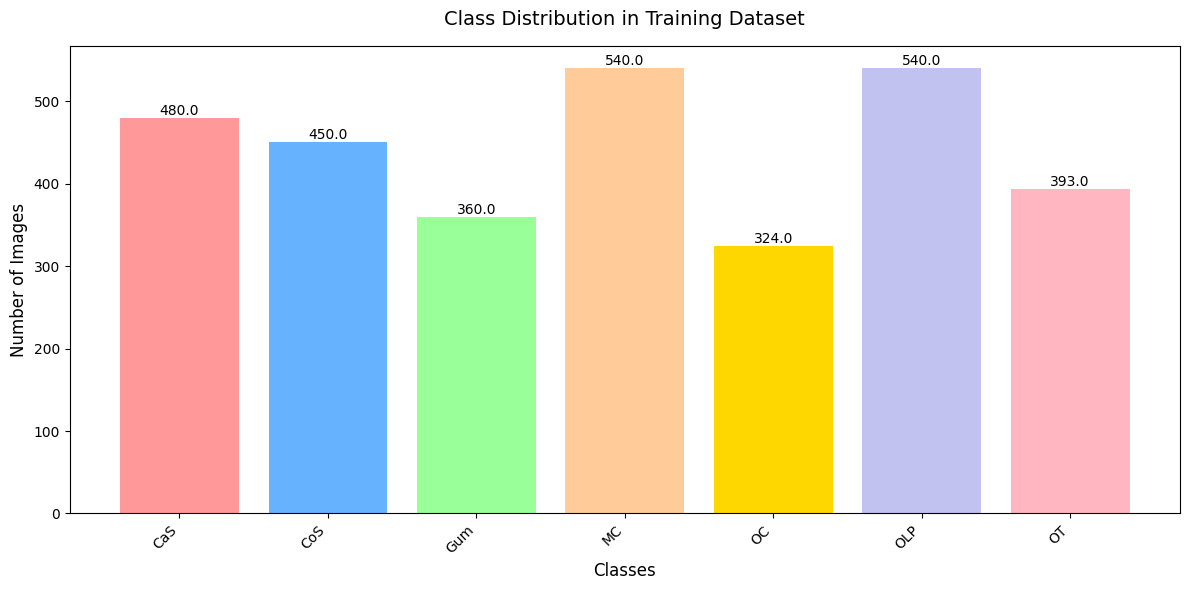

Debugging Augmentation Output:
Original Shape: (224, 224, 3)
Original Min: 0.0000, Max: 0.9994
Augmented Set 1 Min: 0.0000, Max: 0.9994
Augmented Set 2 Min: 0.0000, Max: 0.9994
Augmented Set 3 Min: 0.0000, Max: 1.0000


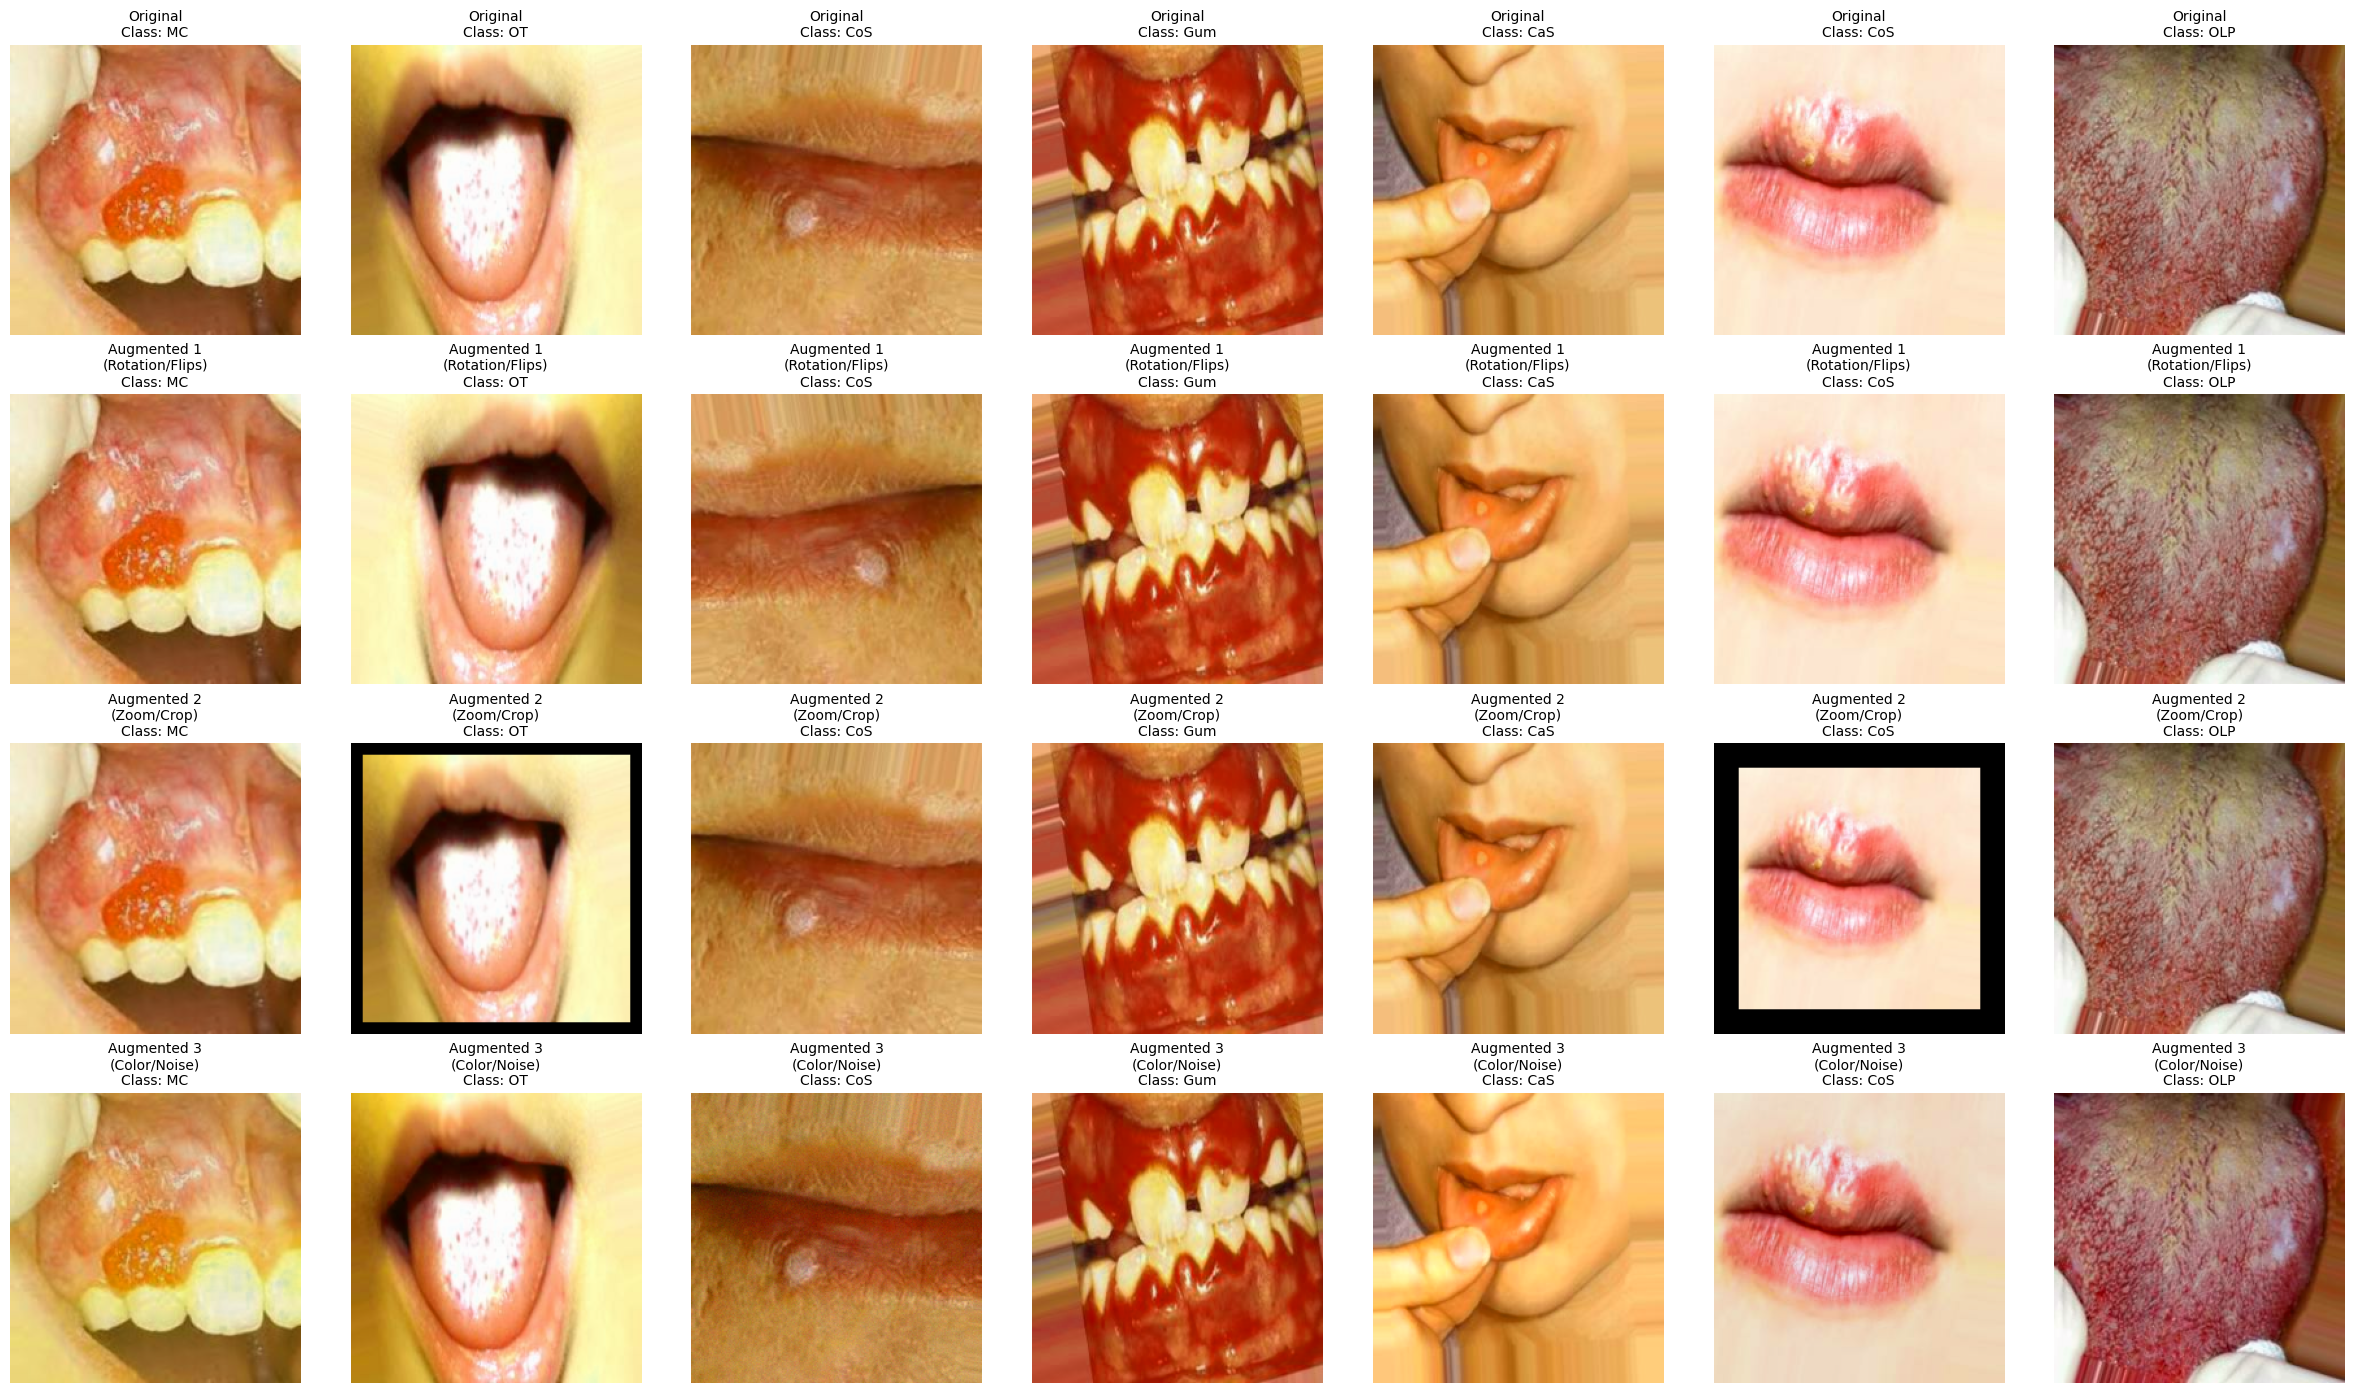

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=1.5, alpha=0.5, name='focal_loss'):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = 7

    def call(self, y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)
        ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
        y_true = tf.cast(y_true, tf.float32)
        p_t = tf.reduce_sum(y_true * tf.nn.softmax(y_pred), axis=-1)
        focal_weight = tf.pow(1.0 - p_t, self.gamma)
        return tf.reduce_mean(self.alpha * focal_weight * ce_loss)

    def get_config(self):
        config = super().get_config()
        config.update({"gamma": self.gamma, "alpha": self.alpha, "num_classes": self.num_classes})
        return config

def plot_class_distribution(dataset, class_names):
    class_counts = np.zeros(len(class_names))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join('/kaggle/input/teeth/Training/', class_name)
        class_counts[i] = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, class_counts, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FFD700', '#C2C2F0', '#FFB6C1'])
    plt.title('Class Distribution in Training Dataset', fontsize=14, pad=15)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    for i, v in enumerate(class_counts):
        plt.text(i, v, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

def plot_augmentation_examples(dataset, class_names):
    for images, labels in dataset.take(1):
        original_images = images.numpy()
        labels = labels.numpy()
        break
    else:
        print("Error: No data available in dataset for visualization.")
        return

    original_images = np.clip(original_images, 0.0, 1.0).astype(np.float32)
    
    def apply_augmentation_set1(images):
        aug_images = []
        for img in images:
            img = tf.convert_to_tensor(img, dtype=tf.float32)
            if tf.random.uniform([]) > 0.5:
                img = tf.image.random_flip_left_right(img)
            if tf.random.uniform([]) > 0.7:
                try:
                    import tensorflow_addons as tfa
                    angle = tf.random.uniform([], -0.2, 0.2)
                    img = tfa.image.rotate(img, angles=angle, interpolation='BILINEAR')
                except (ImportError, AttributeError):
                    print("Warning: tensorflow-addons not found. Rotation disabled in visualization.")
            aug_images.append(tf.clip_by_value(img, 0.0, 1.0))
        return tf.stack(aug_images)

    def apply_augmentation_set2(images):
        aug_images = []
        for img in images:
            img = tf.convert_to_tensor(img, dtype=tf.float32)
            if tf.random.uniform([]) > 0.6:
                zoom_factor = tf.random.uniform([], 0.8, 1.2)
                h, w = tf.shape(img)[0], tf.shape(img)[1]
                new_h = tf.cast(tf.cast(h, tf.float32) * zoom_factor, tf.int32)
                new_w = tf.cast(tf.cast(w, tf.float32) * zoom_factor, tf.int32)
                img = tf.image.resize(img, [new_h, new_w])
                img = tf.image.resize_with_crop_or_pad(img, 224, 224)
            aug_images.append(tf.clip_by_value(img, 0.0, 1.0))
        return tf.stack(aug_images)

    def apply_augmentation_set3(images):
        aug_images = []
        for img in images:
            img = tf.convert_to_tensor(img, dtype=tf.float32)
            if tf.random.uniform([]) > 0.5:
                img = tf.image.random_brightness(img, max_delta=0.1)
            if tf.random.uniform([]) > 0.5:
                img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
            if tf.random.uniform([]) > 0.5:
                img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
            if tf.random.uniform([]) > 0.7:
                img = tf.image.random_hue(img, max_delta=0.05)
            if tf.random.uniform([]) > 0.6:
                noise = tf.random.normal(tf.shape(img), mean=0.0, stddev=0.02)
                img = img + noise
            aug_images.append(tf.clip_by_value(img, 0.0, 1.0))
        return tf.stack(aug_images)

    aug_images_1 = apply_augmentation_set1(original_images)
    aug_images_2 = apply_augmentation_set2(original_images)
    aug_images_3 = apply_augmentation_set3(original_images)
    
    aug_images_1 = np.clip(aug_images_1.numpy(), 0.0, 1.0)
    aug_images_2 = np.clip(aug_images_2.numpy(), 0.0, 1.0)
    aug_images_3 = np.clip(aug_images_3.numpy(), 0.0, 1.0)

    print("Debugging Augmentation Output:")
    print(f"Original Shape: {original_images.shape[1:]}")
    print(f"Original Min: {np.min(original_images):.4f}, Max: {np.max(original_images):.4f}")
    print(f"Augmented Set 1 Min: {np.min(aug_images_1):.4f}, Max: {np.max(aug_images_1):.4f}")
    print(f"Augmented Set 2 Min: {np.min(aug_images_2):.4f}, Max: {np.max(aug_images_2):.4f}")
    print(f"Augmented Set 3 Min: {np.min(aug_images_3):.4f}, Max: {np.max(aug_images_3):.4f}")
    
    num_images = min(7, len(original_images))
    plt.figure(figsize=(24, 14))
    for i in range(num_images):
        plt.subplot(4, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.title(f'Original\nClass: {class_names[int(labels[i])]}', fontsize=10)
        plt.axis('off')
        
        plt.subplot(4, num_images, i + 1 + num_images)
        plt.imshow(aug_images_1[i])
        plt.title(f'Augmented 1\n(Rotation/Flips)\nClass: {class_names[int(labels[i])]}', fontsize=10)
        plt.axis('off')
        
        plt.subplot(4, num_images, i + 1 + 2 * num_images)
        plt.imshow(aug_images_2[i])
        plt.title(f'Augmented 2\n(Zoom/Crop)\nClass: {class_names[int(labels[i])]}', fontsize=10)
        plt.axis('off')
        
        plt.subplot(4, num_images, i + 1 + 3 * num_images)
        plt.imshow(aug_images_3[i])
        plt.title(f'Augmented 3\n(Color/Noise)\nClass: {class_names[int(labels[i])]}', fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, train_class_names)
plot_augmentation_examples(train_dataset, train_class_names)

Num GPUs Available:  1
Starting training on GPU...
Starting first step to verify data...
First Batch Shape: (32, 224, 224, 3), Min: 0.0000, Max: 1.0000
Calculated steps_per_epoch: 96, validation_steps: 32
Epoch 1/500
y_true shape: (None, 7), y_pred shape: (None, 7)
y_true shape: (None, 7), y_pred shape: (None, 7)
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1472 - loss: 0.2742y_true shape: (None, 7), y_pred shape: (None, 7)
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.1480 - loss: 0.2727 - val_accuracy: 0.3330 - val_loss: 0.1735 - learning_rate: 9.7743e-05
Epoch 2/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2540 - loss: 0.1843 - val_accuracy: 0.4600 - val_loss: 0.1554 - learning_rate: 9.1177e-05
Epoch 3/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3569 - loss: 0.1703 - val_accuracy: 0.5352 - val_loss: 0.1431 - learning_rate: 8.0893e-05
Epoch 4/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4285 - loss: 0.1575 - val_accuracy: 0.5

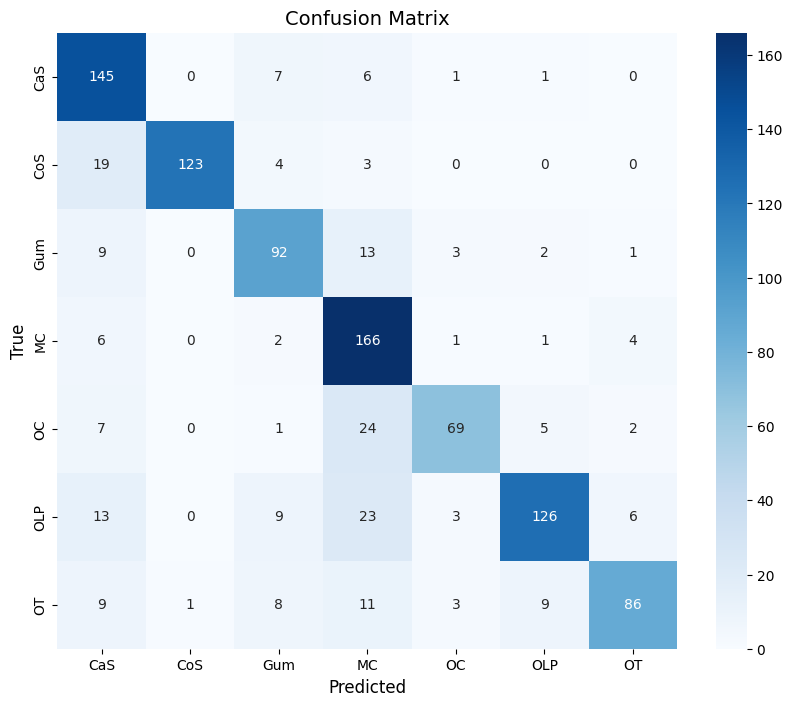

Training completed in 4.99 minutes.


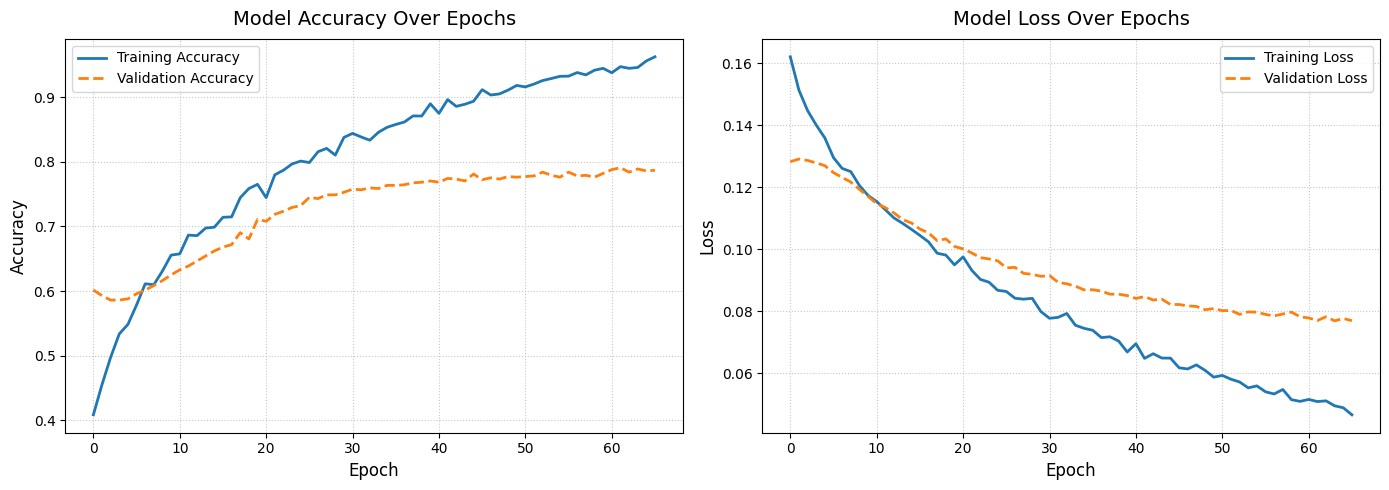

Model saved as /kaggle/working/teeth_classification_model.keras and class names as /kaggle/working/teeth_classification_class_names.pkl.


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=1.5, alpha=0.5, name='focal_loss'):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = 7

    def call(self, y_true, y_pred):
        # Ensure y_true is one-hot encoded with batch dimension
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)  # Shape: (None, 7)
        print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")  # Debug output
        ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
        p_t = tf.reduce_sum(y_true * tf.nn.softmax(y_pred), axis=-1)
        focal_weight = tf.pow(1.0 - p_t, self.gamma)
        return tf.reduce_mean(self.alpha * focal_weight * ce_loss)

    def get_config(self):
        config = super().get_config()
        config.update({"gamma": self.gamma, "alpha": self.alpha, "num_classes": self.num_classes})
        return config

class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= self.threshold:
            print(f"\nReached target validation accuracy of {self.threshold}, stopping training...")
            self.model.stop_training = True

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Starting training on GPU...")

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = Dropout(0.3)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

initial_learning_rate = 0.0001
lr_schedule = CosineDecay(initial_learning_rate, decay_steps=1000)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(loss=FocalLoss(), optimizer=optimizer, metrics=['accuracy'])

y_train = np.concatenate([y for x, y in train_dataset.take(97)], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
accuracy_threshold = AccuracyThresholdCallback(threshold=0.85)

start_time = time.time()

print("Starting first step to verify data...")
for x_batch, y_batch in train_dataset.take(1):
    print(f"First Batch Shape: {x_batch.shape}, Min: {tf.reduce_min(x_batch):.4f}, Max: {tf.reduce_max(x_batch):.4f}")
    break

print(f"Calculated steps_per_epoch: {steps_per_epoch}, validation_steps: {validation_steps}")

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=500,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, accuracy_threshold],
    verbose=1
)

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.00001), loss=FocalLoss(), metrics=['accuracy'])

history_fine = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=85,  # Reduced from 1000 to 75
    initial_epoch=history.epoch[-1] + 1,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, accuracy_threshold],
    verbose=1
)

history.history.update(history_fine.history)

def plot_confusion_matrix(dataset, model, class_names, steps):
    y_true = []
    y_pred = []
    for x_batch, y_batch in dataset.take(steps):
        y_true.extend(y_batch.numpy())
        pred = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(pred, axis=1))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.show()

plot_confusion_matrix(validation_dataset, model, train_class_names, validation_steps)

end_time = time.time()
runtime = end_time - start_time
print(f"Training completed in {runtime / 60:.2f} minutes.")

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('Model Accuracy Over Epochs', fontsize=14, pad=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('Model Loss Over Epochs', fontsize=14, pad=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

model.save('/kaggle/working/teeth_classification_model.keras')
with open('/kaggle/working/teeth_classification_class_names.pkl', 'wb') as f:
    pickle.dump({'class_names': train_class_names}, f)
print("Model saved as /kaggle/working/teeth_classification_model.keras and class names as /kaggle/working/teeth_classification_class_names.pkl.")

In [18]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_9 (Cast)                        │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 37, 37, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 37, 37, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,029,147 (26.81 MB)

 Trainable params: 2,342,407 (8.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 4,684,820 (17.87 MB)